In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '../')

import os
import pickle
import time
import numpy as np
import seaborn as sns

import figure_utils as utils
import matplotlib.pyplot as plt

from truncated_normal import truncated_normal as tn
from scipy.stats import norm, t, truncnorm, ttest_ind

def phi(z): return norm.pdf(z)
def Phi(z): return norm.cdf(z)

%matplotlib inline

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


### T-test v. TN-test

Purpose: 
- visually show how samples come from the same distribution, but clustering induces separation
- show how t-test selective bias gets significantly reduced after switching to tn test (even with var unknown)
- two examples: one with same mean, one with different means

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


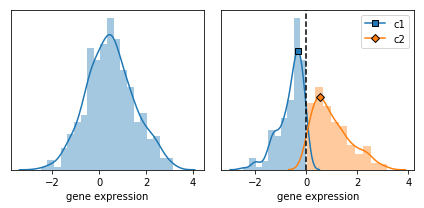

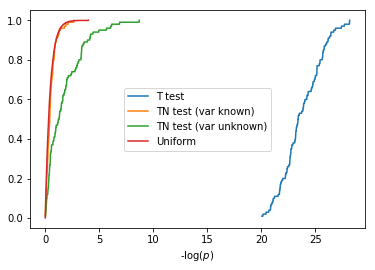

In [2]:
a = 0
mu = 0.5
muL = mu
muR = mu
Cov = 1

n = 500
nY = int(n*(1-Phi(muL)))
nZ = n-nY

np.random.seed(0)
y = truncnorm.rvs(a=-np.inf, b=a-muL, loc=muL, scale=np.sqrt(Cov), size=159)
z = truncnorm.rvs(a=a-muR, b=np.inf, loc=muR, scale=np.sqrt(Cov), size=341)

utils.plot_1D(y, z, a)

picklefile = 'pickled/sim_1d_null.pickle'
if os.path.isfile(picklefile):
    curves = pickle.load(open(picklefile, 'rb'))
else:
    curves = utils.run_simulation_1D(a, muL, muR, Cov)
    pickle.dump(curves, open(picklefile, 'wb'))
plt.figure()
utils.plot_ecdfs(curves, logmode=False)

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


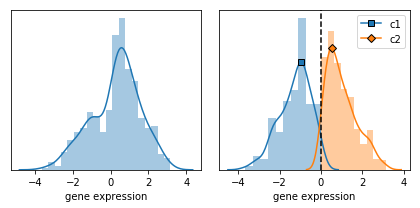

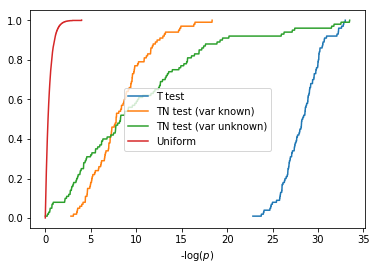

In [3]:
# repeat for when an actual difference exists

a = 0
muL = -1
muR = 0.5

np.random.seed(0)

y = truncnorm.rvs(a=-np.inf, b=a-muL, loc=muL, scale=np.sqrt(Cov), size=159)
z = truncnorm.rvs(a=a-muR, b=np.inf, loc=muR, scale=np.sqrt(Cov), size=341)

utils.plot_1D(y, z, a)

picklefile = 'pickled/sim_1d_alt_intercept.pickle'
if os.path.isfile(picklefile):
    curves = pickle.load(open(picklefile, 'rb'))
else:
    curves = utils.run_simulation_1D(a, muL, muR, Cov)
    pickle.dump(curves, open(picklefile, 'wb'))
plt.figure()
utils.plot_ecdfs(curves, logmode=False)

### Simulation on 2D case (p value distribution)

2 changes from above (to show that p value distribution issues are still seen
- extend to 2 dimensions
- shift null mean off of hyperplane

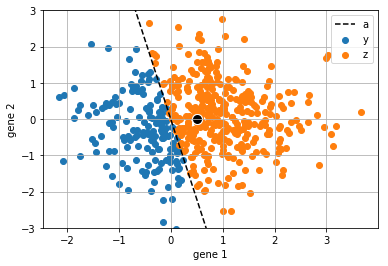

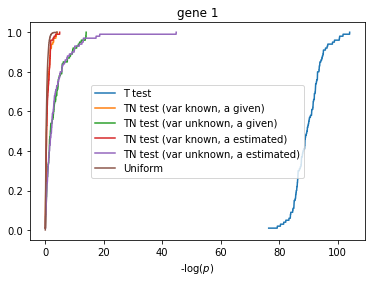

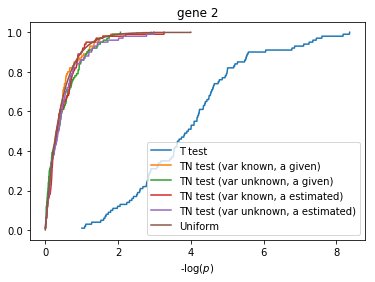

In [4]:
np.random.seed(0)
a = np.random.normal(0, 1, 2)
a /= np.linalg.norm(a)
b = 0
mu = np.array([0.5, 0])
muL = mu
muR = mu
Cov = np.array([1., 1.])

n = 500
nY = int(n*Phi(-np.dot(a, muL)/np.sqrt(np.dot(a, Cov*a))))
nZ = n-nY

y = utils.truncnormmv(muL, Cov, -a, b, nY)
z = utils.truncnormmv(muR, Cov, a, b, nZ)

utils.plot_2D(a, y, z, muL=muL, muR=muR)

picklefile = 'pickled/sim_2d_null_svm.pickle'
if os.path.isfile(picklefile):
    curves = pickle.load(open(picklefile, 'rb'))
else:
    curves = utils.run_simulation(muL, muR, Cov, nY=nY, nZ=nZ, a_init=a, 
                                  split_prop=0.1, eps=1e-2)
    pickle.dump(curves, open(picklefile, 'wb'))

for i in range(2):
    curves_ = {label:curves[label][:, i] for label in curves}
    plt.figure()
    utils.plot_ecdfs(curves_, title='gene %s'%(i+1), logmode=False)

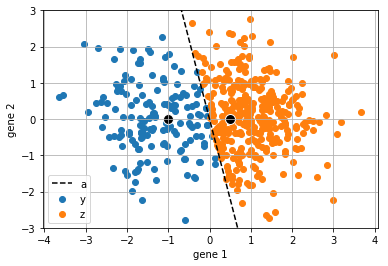

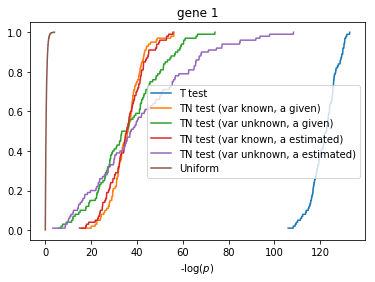

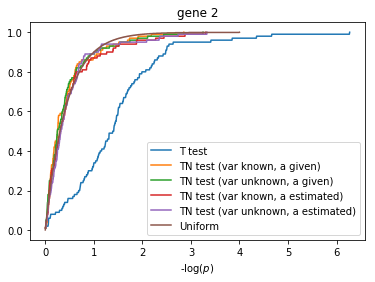

In [5]:
# changing only the mean of gene 1 in one of the distributions
np.random.seed(0)
muL = np.array([-1.0, 0])
muR = np.array([0.5, 0])

y = utils.truncnormmv(muL, Cov, -a, b, nY)
z = utils.truncnormmv(muR, Cov, a, b, nZ)

utils.plot_2D(a, y, z, muL=muL, muR=muR)

picklefile = 'pickled/sim_2d_alt_svm.pickle'
if os.path.isfile(picklefile):
    curves = pickle.load(open(picklefile, 'rb'))
else:
    curves = utils.run_simulation(muL, muR, Cov, nY=nY, nZ=nZ, a_init=a, 
                                  split_prop=0.1, eps=1e-5)
    pickle.dump(curves, open(picklefile, 'wb'))

for i in range(2):
    curves_ = {label:curves[label][:, i] for label in curves}
    plt.figure()
    utils.plot_ecdfs(curves_, title='gene %s'%(i+1), logmode=False)

### p value distribution of most significant gene as dimension increases

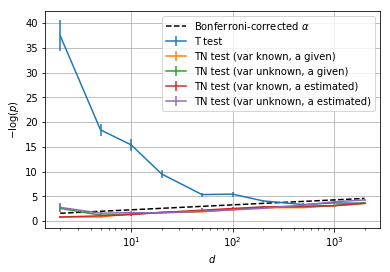

In [6]:
np.random.seed(1)

picklefile = 'pickled/sim_dsweep_null_svm.pickle'
d_list = [2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000]
num_sims = 10
nY = 100
nZ = 100

if os.path.isfile(picklefile):
    results = pickle.load(open(picklefile, 'rb'))
else:
    results = {}

for d in d_list:
    if d in results: continue
    print('\nProcessing d = %s..'%(d))
    muL = np.zeros(d)
    muR = np.zeros(d)
    Cov = np.ones(d)
    results[d] = utils.run_simulation(muL, muR, Cov, nY=nY, nZ=nZ,
                                      num_sims=num_sims, split_prop=0.5, verbose=True)
    pickle.dump(results, open(picklefile, 'wb'))
    
    
curve_types = list(results[d_list[0]].keys())
num_sims = len(results[d_list[0]][curve_types[0]])
alpha = 0.05

for curve_type in curve_types:
    curve_set = [np.min(results[d][curve_type], 1) for d in d_list]
    means = [np.mean(-np.log10(curve)) for curve in curve_set]
    ses = [np.std(-np.log10(curve)/np.sqrt(num_sims)) for curve in curve_set]
    plt.errorbar(d_list, means, yerr=ses, label=curve_type)
    
plt.plot(d_list, -np.log10([alpha/d for d in d_list]), '--', 
         c='k', label=r'Bonferroni-corrected $\alpha$')

plt.xlabel(r'$d$')
plt.xscale('log')
plt.ylabel(r'$-\log(p)$')
plt.grid()
plt.legend()
plt.show()    

### High dimensional simulation with differential expression

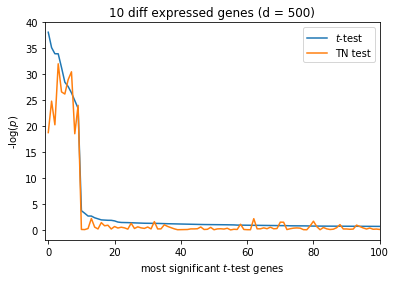

In [7]:
np.random.seed(0)

d = 500
nY = 100
nZ = 100
muL = np.zeros(d)
muL[:10] = -1
muR = np.zeros(d)
muR[:10] = 1
Cov = np.ones(d)
    
picklefile = 'pickled/sim_dsweep_alt.pickle'

if os.path.isfile(picklefile):
    p_t, p_tn = pickle.load(open(picklefile, 'rb'))
else:
    _, _, a, b = utils.simulate_hyperplane(muL, muR, Cov, nY, nZ)

    y = utils.truncnormmv(muL, Cov, -a, -b, nY)
    z = utils.truncnormmv(muR, Cov, a, b, nZ)

    p_t = ttest_ind(y, z)[1]
    p_tn = tn.tn_test(y, z, split_prop=0.1, eps=1e-2, verbose=True)

    pickle.dump((p_t, p_tn), open(picklefile, 'wb'))

curves = {
    '$t$-test': p_t,
    'TN test': p_tn
}

plt.figure()
plt.plot(-np.log10(np.sort(p_t)[:200]), label='$t$-test')
plt.plot(-np.log10(p_tn), label='TN test')
plt.xlabel('most significant $t$-test genes')
plt.ylabel('-log($p$)')
plt.title('10 diff expressed genes (d = %s)'%(d))
plt.xlim(-1, 100)
plt.legend()
plt.show()